In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.mlab as mlab
from scipy.stats import norm

%matplotlib inline
import matplotlib.gridspec as gridspec
plt.rcParams['font.family']='serif'

In [43]:
###===========
# This section imports the necessary columns from the csv file into numpy arrays
###===========

csv = np.genfromtxt ('RadioDetectionTable_Limits.csv', delimiter=",")
LV = csv[1:,7]
LV_err=csv[1:,8] 
LV_err = LV_err/LV
LV=np.log10(LV) #convert to natural log basis
LV_err= 0.1*LV
Conf_index = csv[1:,10]
Conf_index = Conf_index.astype(int) #will index which values are confirmed dections
Conf_index = Conf_index == 0
UL_index = np.logical_not(Conf_index) #will index uplims

##Possible parameter-axes
spectype = csv[1:,2] 

t_eff = csv[1:,13]
temp_err = csv[1:,14]

vsini = csv[1:,3]
vsini_err = csv[1:,16]

##Dividing 3sigma uplims by 3 and adding error bar of 1sigma
LVconf = LV[Conf_index]
LVconf_err = LV_err[Conf_index]
# err_av=np.mean(LVconf_err)

LVuplim = LV[UL_index]
LVuplim_conf = LVuplim/3
#LVuplim_err = np.full((1, (len(LVuplim))), err_av)
LVuplim_err = LVuplim_conf

LVtotal = np.concatenate((LVconf, LVuplim))

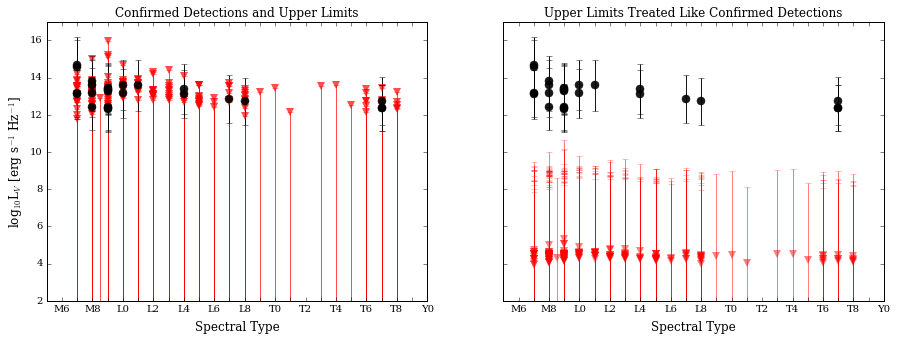

In [86]:
###===========
# This section plots the data, 1 with uplims and one with uplims-->confirmed, vs. temperature
###===========

spectype_conf = spectype[Conf_index]
spectype_ul = spectype[UL_index]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

labels = ['','M6','','M8','','L0','','L2','','L4','','L6','','L8','',
          'T0','','T2','','T4','','T6','','T8','', 'Y0']
ax1.set_xticks(np.arange(5,31,1))
ax1.set_xticklabels(labels)
ax1.errorbar(spectype_ul, LVuplim, yerr=LVuplim, uplims=np.ones(sum(UL_index), dtype=bool), ls='', c='red', markersize='8', markeredgecolor='None', alpha=0.7, fmt="v")
ax1.errorbar(spectype_conf, LVconf, yerr=LVconf_err, ls='', c='k', markersize='8', markeredgecolor=None, alpha=0.9, fmt="o")

ax1.set_xlim(5,30)
ax1.set_ylim(2,17)
ax1.set_xlabel('Spectral Type', fontsize=12, labelpad=7)
ax1.set_ylabel('log$_{10}$L$_V$ [erg s$^{-1}$ Hz$^{-1}$]', fontsize=12)
ax1.set_title('Confirmed Detections and Upper Limits')

ax2.set_xticks(np.arange(5,31,1))
ax2.set_xticklabels(labels)
ax2.errorbar(spectype_ul, LVuplim_conf, yerr=LVuplim_err, ls='', c='red', markersize='8', markeredgecolor='None', alpha=0.5, fmt="v")
ax2.errorbar(spectype_conf, LVconf, yerr=LVconf_err, ls='', c='k', markersize='8', markeredgecolor=None, alpha=0.9, fmt="o")

ax2.set_xlim(5,30)
ax2.set_xlabel('Spectral Type', fontsize=12, labelpad=7)
ax2.set_title('Upper Limits Treated Like Confirmed Detections')

# plt.tight_layout()

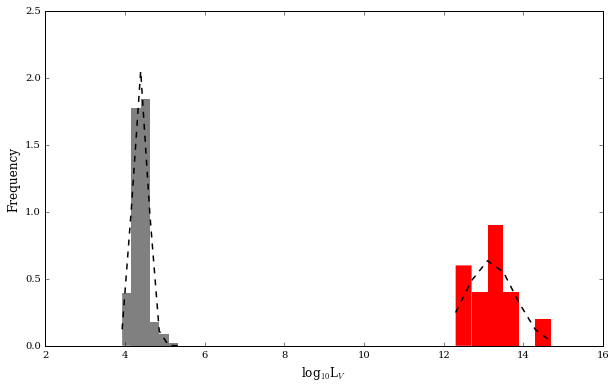

In [61]:
###===========
# This section plots histogram to extract priors
###===========

plt.figure(figsize=(10,6))

(mu_l, sigma_l) = norm.fit(LVconf) #mu is mean, sigma is width
n, bins, patches = plt.hist(LVconf, bins=6, normed=True, facecolor='red', edgecolor='none')
y = mlab.normpdf(bins, mu_l, sigma_l)
l = plt.plot(bins, y, 'k--', linewidth=1.5)

(mu_q, sigma_q) = norm.fit(LVuplim_conf)
m, bins2, patches2 = plt.hist(LVuplim_conf, bins=6, normed=True, facecolor='grey', edgecolor='none')
z = mlab.normpdf(bins2, mu_q, sigma_q)
l = plt.plot(bins2, z, 'k--', linewidth=1.5)

plt.xlabel("log$_{10}$L$_V$", fontsize='12')
plt.ylabel("Frequency", fontsize='12')
plt.savefig('histograms.png')

In [117]:
###===========
# This section plots likelihood function for simplest model
###===========

#Likelihood function is: L=(1-P)N(y_n|mu_q, var_q) + P*N(y_n|mu_l, var_l)

P = 0.5
mu_q = np.average(LVuplim_conf, weights=LVuplim_err) #xi from histogram above
var_q = np.var(LVuplim_conf) # var_q = sigma_q**2 from histogram above
mu_l = np.average(LVconf, weights=LVconf_err) #mu from histogram above
var_l = np.var(LVconf) # var_l = sigma_l**2 from histogram above
pi = math.pi

P_array=[]
total_array=[]
likelihood_array=[]
for P in np.arange(0.2,1.1,0.1):
    Likelihood = (1-P)*(1/np.sqrt(2*pi*var_q))*(np.exp((-1/2)*((LVtotal-mu_q)**2)/var_q)) + P*(1/np.sqrt(2*pi*var_l))*(np.exp((-1/2)*((LVtotal-mu_l)**2)/var_l))
## QUESTION FOR HOGG:
## Should I be using the entire array of LV on  each, including confirmed and uplims
    total = np.sum(np.log10(Likelihood))
    likelihood_array.append(np.sum(Likelihood))
    P_array.append(P)
    total_array.append(total)
    print "P value is %s, Sum of ln(Likelihood) is %s" %(P, total)

P value is 0.2, Sum of ln(Likelihood) is -282.447756625
P value is 0.3, Sum of ln(Likelihood) is -243.531588373
P value is 0.4, Sum of ln(Likelihood) is -215.920127583
P value is 0.5, Sum of ln(Likelihood) is -194.503014708
P value is 0.6, Sum of ln(Likelihood) is -177.003959332
P value is 0.7, Sum of ln(Likelihood) is -162.208718823
P value is 0.8, Sum of ln(Likelihood) is -149.392498541
P value is 0.9, Sum of ln(Likelihood) is -138.08779108
P value is 1.0, Sum of ln(Likelihood) is -127.975385666


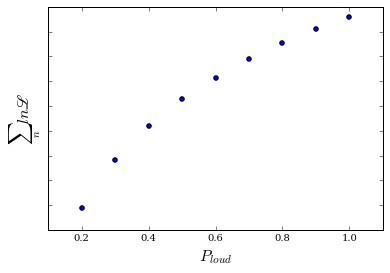

In [119]:
###===========
# This section plots Hogg's graph test
###===========

plt.scatter(P_array, total_array)
plt.xlabel("$P_{loud}$", fontsize='16')
plt.ylabel("$\sum_{n} ln\mathscr{L}$", fontsize='16')
plt.tick_params(axis='y', labelleft='off')